In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Aug 31 18:52:20 2023

@author: KIM
"""

import numpy as np
import torch
from torch.nn import Softplus

from pina.problem import SpatialProblem
from pina.operators import nabla, grad, div, advection
from pina import Condition, Span, LabelTensor
from pina.model import FeedForward
from pina import Condition, Span, PINN, Plotter
import matplotlib.pyplot as plt
import time
# ========================================================================== #
#                                                                            #
#  This script implements steady two dimensional Lid-driven Cavity problem.  #
#  Steady two dimensional Lid-driven Cavity problem is inheriting from       #
#  SpatialProblem.                                                           #
#  We  denote:                                                               #
#           ux --> field variable velocity along x                           #
#           uy --> field variable velocity along y                           #
#           p --> field variable pressure                                    #
#           x,y --> spatial variables                                        #
#                                                                            #
# ========================================================================== #


class Cavity(SpatialProblem):
    # assign output/ spatial variables
    output_variables = ['ux', 'uy', 'p']
    spatial_domain = Span({'x': [0, 1], 'y': [0, 1]})

    #define the momentum equation
    def momentum(input_, output_):

        adv_u = advection(output_.extract(['ux','uy']), input_, ['ux','uy'])

        nabla_ = torch.hstack((LabelTensor(nabla(output_.extract(['ux']), input_), ['x']),
            LabelTensor(nabla(output_.extract(['uy']), input_), ['y'])))
        Re = 100.0

        grad_p = grad(output_.extract(['p']), input_)
        return adv_u + grad_p - 1/Re * nabla_


    #define the continuity equation
    def continuity(input_, output_):
        a = ['ux', 'uy']
        return div(output_.extract(a), input_)

    # define the wall condition
    def wall(input_, output_):
        value = 0.0
        return output_.extract(['ux', 'uy']) -value

    # define the lid-ux condition
    def lid_ux (input_, output_):
        value = 1.0
        return output_.extract(['ux']) -value

    # define the lid-uy condition
    def lid_uy (input_, output_):
        value = 0.0
        return output_.extract(['uy']) -value

    # define vorticity condition
    def vorticity(input_, output_):
        u_y = grad(output_, input_, components=['ux'], d=['y'])
        v_x = grad(output_, input_, components=['uy'], d=['x'])
        return torch.abs(u_y - v_x)

    # problem condition statement
    conditions = {
        'wall_left': Condition(location=Span({'x': 0, 'y': [0, 1]}), function=wall),
        'wall_bottom': Condition(location=Span({'x': [0, 1], 'y': 0}), function=wall),
        'wall_right': Condition(location=Span({'x':  1, 'y': [0, 1]}), function=wall),
        'lid_ux':  Condition(location=Span({'x': [0, 1], 'y': 1}), function=lid_ux),
        'lid_uy':  Condition(location=Span({'x': [0, 1], 'y': 1}), function=lid_uy),
        'D1': Condition(location=Span({'x': [0, 1], 'y': [0, 1]}), function=momentum),
        'D2': Condition(location=Span({'x': [0, 1], 'y': [0, 1]}), function=continuity),
        'vorticity': Condition(location=Span({'x': [0, 1], 'y': [0, 1]}), function=vorticity, data_weight=0.),
    }


              sum          wall_leftwal wall_bottomw wall_rightwa lid_uxlid_ux lid_uylid_uy D1momentum   D2continuity vorticityvor 
[epoch 00000] 7.636493e-01 2.628084e-02 2.244927e-02 1.800563e-02 6.950321e-01 1.851715e-03 1.272963e-05 1.694271e-05 0.000000e+00 
              sum          wall_leftwal wall_bottomw wall_rightwa lid_uxlid_ux lid_uylid_uy D1momentum   D2continuity vorticityvor 
[epoch 00001] 7.063364e-01 1.905813e-02 1.844559e-02 1.817926e-02 6.501764e-01 4.470738e-04 1.449958e-05 1.548099e-05 0.000000e+00 
              sum          wall_leftwal wall_bottomw wall_rightwa lid_uxlid_ux lid_uylid_uy D1momentum   D2continuity vorticityvor 
[epoch 00500] 5.508006e-02 1.976077e-02 1.104394e-04 2.260632e-02 3.994578e-03 3.115057e-04 6.304769e-03 1.991675e-03 0.000000e+00 
              sum          wall_leftwal wall_bottomw wall_rightwa lid_uxlid_ux lid_uylid_uy D1momentum   D2continuity vorticityvor 
[epoch 01000] 5.138028e-02 1.667814e-02 1.079819e-04 1.948112e-02 8.894403e-

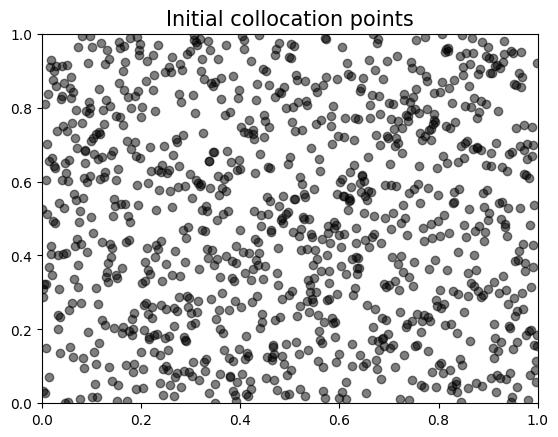

              sum          wall_leftwal wall_bottomw wall_rightwa lid_uxlid_ux lid_uylid_uy D1momentum   D2continuity vorticityvor 
[epoch 10000] 3.613011e+00 1.455506e-03 6.856362e-05 1.855659e-03 8.546209e-03 4.124007e-04 3.026520e+00 5.741525e-01 0.000000e+00 
              sum          wall_leftwal wall_bottomw wall_rightwa lid_uxlid_ux lid_uylid_uy D1momentum   D2continuity vorticityvor 
[epoch 10001] 6.147126e-01 1.851361e-03 2.934274e-03 1.129294e-02 5.433778e-01 2.158082e-03 1.568568e-02 3.741238e-02 0.000000e+00 
              sum          wall_leftwal wall_bottomw wall_rightwa lid_uxlid_ux lid_uylid_uy D1momentum   D2continuity vorticityvor 
[epoch 10100] 4.314738e-02 1.260913e-02 1.062839e-04 1.748724e-02 5.060323e-03 1.449119e-03 4.187437e-03 2.247849e-03 0.000000e+00 
              sum          wall_leftwal wall_bottomw wall_rightwa lid_uxlid_ux lid_uylid_uy D1momentum   D2continuity vorticityvor 
[epoch 10200] 3.795914e-02 1.038343e-02 1.744402e-04 1.596543e-02 4.092726e-

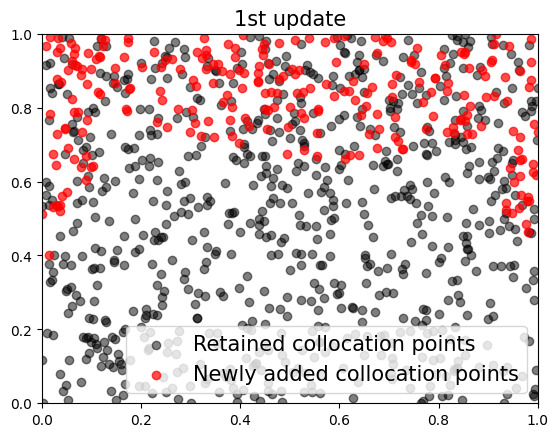

              sum          wall_leftwal wall_bottomw wall_rightwa lid_uxlid_ux lid_uylid_uy D1momentum   D2continuity vorticityvor 
[epoch 15000] 3.478234e-02 5.174699e-03 7.002212e-05 6.732171e-03 1.220039e-03 1.025544e-03 1.881146e-02 1.748401e-03 0.000000e+00 
              sum          wall_leftwal wall_bottomw wall_rightwa lid_uxlid_ux lid_uylid_uy D1momentum   D2continuity vorticityvor 
[epoch 15001] 1.074132e-01 2.230066e-03 4.028968e-05 6.467268e-03 8.659057e-02 2.887570e-04 9.017244e-03 2.779051e-03 0.000000e+00 
              sum          wall_leftwal wall_bottomw wall_rightwa lid_uxlid_ux lid_uylid_uy D1momentum   D2continuity vorticityvor 
[epoch 15100] 1.540429e-02 5.100455e-03 6.542633e-05 5.647785e-03 1.122919e-03 1.033602e-03 1.515193e-03 9.189091e-04 0.000000e+00 
              sum          wall_leftwal wall_bottomw wall_rightwa lid_uxlid_ux lid_uylid_uy D1momentum   D2continuity vorticityvor 
[epoch 15200] 1.712309e-02 4.039688e-03 8.991959e-05 4.928259e-03 1.622073e-

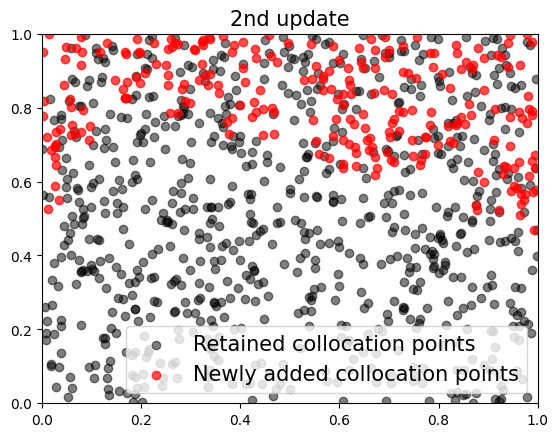

Cavity vorti test loss: [LabelTensor([-0.0523, -0.0044], grad_fn=<AliasBackward0>), LabelTensor([-0.0151], grad_fn=<AliasBackward0>)]
Total time wo vorti: 937.5836160182953 [s]


In [21]:
time_init = time.time()
problem=Cavity()

model = FeedForward(
    layers=[20]*5,
    func=torch.nn.Tanh,
    output_variables=problem.output_variables,
    input_variables=problem.input_variables
)

pinn = PINN(problem, model, lr=1e-3, regularizer=1e-8)
pinn.span_pts(1000, 'latin', seed=42, locations=['D1', 'D2'])
pinn.span_pts(400, 'grid', seed=42, locations=['wall_left', 'wall_bottom', 'wall_right', 'lid_ux', 'lid_uy'])
pinn.span_pts(1, 'random', locations=['vorticity'])
pinn.train(10000, 500) # 20000 iter

plt.scatter(pinn.input_pts['D1'][:,0].detach().numpy(), pinn.input_pts['D1'][:,1].detach().numpy(),alpha=0.5, color='k')
plt.title('Initial collocation points', fontsize=15)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

N_adapt = 250
for i in range(2):
    pinn.update_pts(N_adapt, weight_mass=0.7, locations=['D1', 'D2', 'vorticity'])
    plt.scatter(pinn.input_pts['D1'][:,0][:-N_adapt].detach().numpy(), pinn.input_pts['D1'][:,1][:-N_adapt].detach().numpy(), alpha=0.5, color='k', label="Retained collocation points")
    plt.scatter(pinn.input_pts['D1'][:,0][-N_adapt:].detach().numpy(), pinn.input_pts['D1'][:,1][-N_adapt:].detach().numpy(), alpha=.7, color='r', label="Newly added collocation points")

    pinn.train(5000, 100)
    if i ==0:
        plt.title(f'{i+1}st update', fontsize=15)
    elif i ==1:
        plt.title(f'{i+1}nd update', fontsize=15)
    plt.legend(fontsize=15, loc='lower right', frameon=True)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()
print(f"Cavity vorti test loss: {pinn.cal_loss()}")
print(f"Total time wo vorti: {time.time()-time_init} [s]")

In [19]:
""" Module for plotting. """
import matplotlib.pyplot as plt
import numpy as np
import torch

from pina import LabelTensor


class Plotter_local:
    """
    Implementation of a plotter class, for easy visualizations.
    """

    def plot_samples(self, pinn, variables=None):
        """
            Plot a sample of solution.

        :param PINN pinn: the PINN object.
        :param list(str) variables: variables to plot. If None, all variables
            are plotted. If 'spatial', only spatial variables are plotted. If
            'temporal', only temporal variables are plotted. Defaults to None.

        .. todo::
            - Add support for 3D plots.
            - Fix support for more complex problems.

        :Example:
            >>> plotter = Plotter()
            >>> plotter.plot_samples(pinn=pinn, variables='spatial')
        """

        if variables is None:
            variables = pinn.problem.domain.variables
        elif variables == 'spatial':
            variables = pinn.problem.spatial_domain.variables
        elif variables == 'temporal':
            variables = pinn.problem.temporal_domain.variables

        if len(variables) not in [1, 2, 3]:
            raise ValueError

        fig = plt.figure()
        proj = '3d' if len(variables) == 3 else None
        ax = fig.add_subplot(projection=proj)
        for location in pinn.input_pts:
            coords = pinn.input_pts[location].extract(variables).T.detach()
            if coords.shape[0] == 1:  # 1D samples
                ax.plot(coords[0], torch.zeros(coords[0].shape), '.',
                        label=location)
            else:
                ax.plot(*coords, '.', label=location)

        ax.set_xlabel(variables[0])
        try:
            ax.set_ylabel(variables[1])
        except:
            pass

        try:
            ax.set_zlabel(variables[2])
        except:
            pass

        plt.legend()
        plt.show()

    def _1d_plot(self, pts, pred, method, truth_solution=None, **kwargs):
        """Plot solution for one dimensional function

        :param pts: Points to plot the solution.
        :type pts: torch.Tensor
        :param pred: PINN solution evaluated at 'pts'.
        :type pred: torch.Tensor
        :param method: not used, kept for code compatibility
        :type method: None
        :param truth_solution: Real solution evaluated at 'pts',
            defaults to None.
        :type truth_solution: torch.Tensor, optional
        """
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

        ax.plot(pts, pred.detach(), **kwargs)

        if truth_solution:
            truth_output = truth_solution(pts).float()
            ax.plot(pts, truth_output.detach(), **kwargs)

        plt.xlabel(pts.labels[0])
        plt.ylabel(pred.labels[0])
        plt.show()

    def _2d_plot(self, pts, pred, v, res, method, components, truth_solution=None,
                 **kwargs):
        """Plot solution for two dimensional function

        :param pts: Points to plot the solution.
        :type pts: torch.Tensor
        :param pred: PINN solution evaluated at 'pts'.
        :type pred: torch.Tensor
        :param method: matplotlib method to plot 2-dimensional data,
            see https://matplotlib.org/stable/api/axes_api.html for
            reference.
        :type method: str
        :param truth_solution: Real solution evaluated at 'pts',
            defaults to None.
        :type truth_solution: torch.Tensor, optional
        """

        grids = [p_.reshape(res, res) for p_ in pts.extract(v).cpu().T]

        pred_output = pred.reshape(res, res)
        if truth_solution:
            truth_output = truth_solution(pts).float().reshape(res, res)
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

            cb = getattr(ax[0], method)(
                *grids, pred_output.cpu().detach(), **kwargs)
            fig.colorbar(cb, ax=ax[0])
            cb = getattr(ax[1], method)(
                *grids, truth_output.cpu().detach(), **kwargs)
            fig.colorbar(cb, ax=ax[1])
            cb = getattr(ax[2], method)(*grids,
                                        (truth_output-pred_output).cpu().detach(),
                                        **kwargs)
            fig.colorbar(cb, ax=ax[2])
        else:
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

            if "ux" in components:
                levels = np.linspace(-0.2, 1.0, 101)
                # cb = getattr(ax, method)(
                #     *grids, pred_output.cpu().detach(), levels=levels, cmap='jet', **kwargs)
            elif "uy" in components:
                levels = np.linspace(-0.5, 0.3, 100)
                # cb = getattr(ax, method)(
                #     *grids, pred_output.cpu().detach(), 100, vmin=-0.5, vmax=0.3, cmap='jet', **kwargs)
            elif "p" in components:
                levels = np.linspace(-1, 2.0, 100)
                # cb = getattr(ax, method)(
                #     *grids, pred_output.cpu().detach(), 100, vmin=-1., vmax=2., cmap='jet', **kwargs)
            cb = getattr(ax, method)(
                    *grids, pred_output.cpu().detach(), levels=levels, cmap='jet', **kwargs)
            # fig.colorbar(cb, ax=ax, ticks=np.linspace(levels.min(),levels.max(),6))

    def plot(self, pinn, components=None, fixed_variables={}, method='contourf',
             res=256, filename=None, **kwargs):
        """
        Plot sample of PINN output.

        :param PINN pinn: the PINN object.
        :param list(str) components: the output variable to plot. If None, all
            the output variables of the problem are selected. Default value is
            None.
        :param dict fixed_variables: a dictionary with all the variables that
            should be kept fixed during the plot. The keys of the dictionary
            are the variables name whereas the values are the corresponding
            values of the variables. Defaults is `dict()`.
        :param {'contourf', 'pcolor'} method: the matplotlib method to use for
            plotting the solution. Default is 'contourf'.
        :param int res: the resolution, aka the number of points used for
            plotting in each axis. Default is 256.
        :param str filename: the file name to save the plot. If None, the plot
            is shown using the setted matplotlib frontend. Default is None.
        """
        if components is None:
            components = [pinn.problem.output_variables]
        v = [
            var for var in pinn.problem.input_variables
            if var not in fixed_variables.keys()
        ]
        pts = pinn.problem.domain.sample(res, 'grid', variables=v)

        fixed_pts = torch.ones(pts.shape[0], len(fixed_variables))
        fixed_pts *= torch.tensor(list(fixed_variables.values()))
        fixed_pts = fixed_pts.as_subclass(LabelTensor)
        fixed_pts.labels = list(fixed_variables.keys())

        pts = pts.append(fixed_pts)
        pts = pts.to(device=pinn.device)

        predicted_output = pinn.model(pts)
        if isinstance(components, str):
            predicted_output = predicted_output.extract(components)
        elif callable(components):
            predicted_output = components(predicted_output)
        truth_solution = getattr(pinn.problem, 'truth_solution', None)
        if len(v) == 1:
            self._1d_plot(pts, predicted_output, method, truth_solution,
                          **kwargs)
        elif len(v) == 2:
            self._2d_plot(pts, predicted_output, v, res, method, components,
                          truth_solution, **kwargs)

        if filename:
            # plt.title('Output {} with parameter {}'.format(components,
            #                                                fixed_variables))
            plt.savefig(filename)
        else:
            plt.show()

    def plot_loss(self, pinn, label=None, log_scale=True, filename=None):
        """
        Plot the loss function values during traininig.

        :param PINN pinn: the PINN object.
        :param str label: the label to use in the legend, defaults to None.
        :param bool log_scale: If True, the y axis is in log scale. Default is
            True.
        :param str filename: the file name to save the plot. If None, the plot
            is not saved. Default is None.
        """

        if not label:
            label = str(pinn)

        epochs = list(pinn.history_loss.keys())
        loss = np.array(list(pinn.history_loss.values()))

        # if multiple outputs, sum the loss
        if loss.ndim != 1:
            loss = np.sum(loss, axis=1)

        # plot loss
        plt.plot(epochs, loss, label=label)
        plt.legend()
        if log_scale:
            plt.yscale('log')
        plt.title('Loss function')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        # save plot
        if filename:
            plt.savefig(filename)


Total time wo vorti: 2643.999037027359 [s]


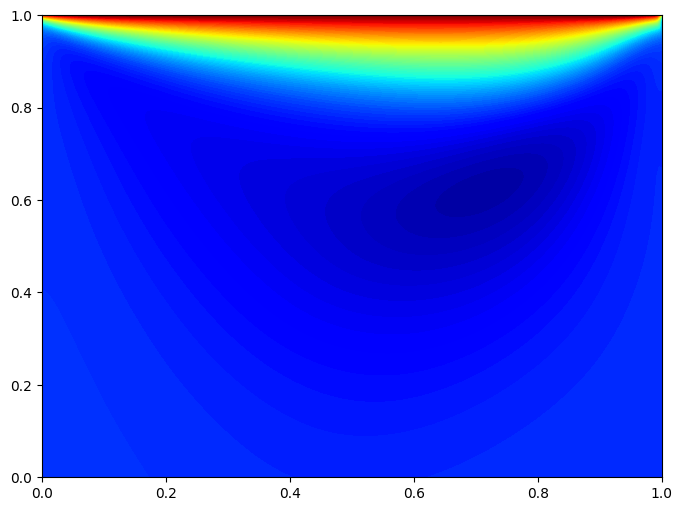

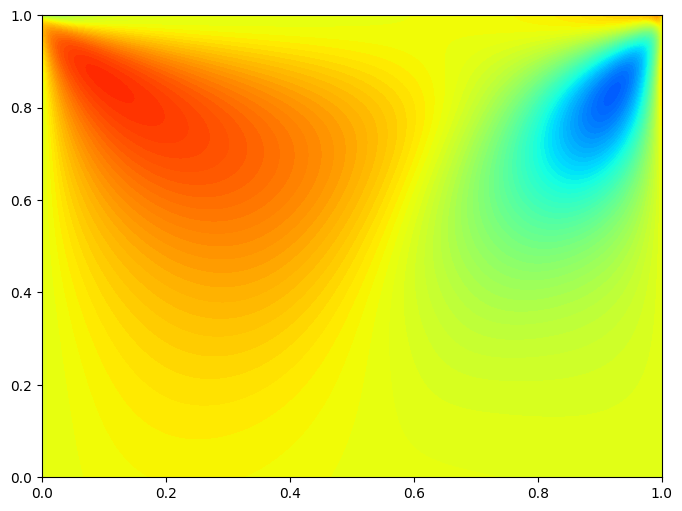

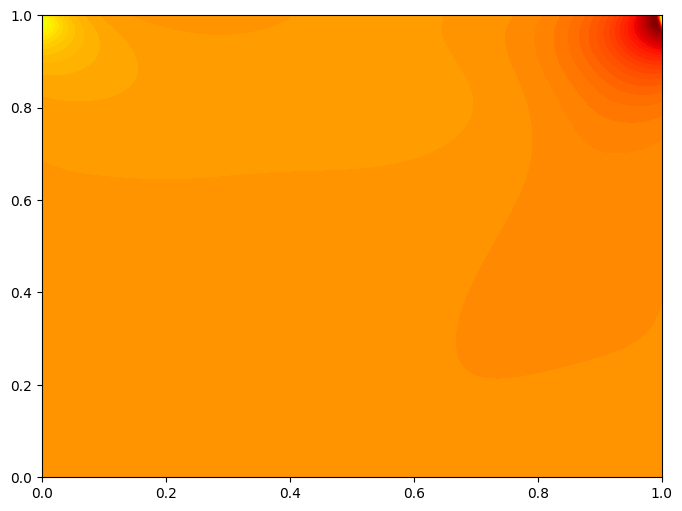

In [20]:
plotter = Plotter_local()
plotter.plot(pinn, components='ux', filename="ux_Vanially")
plotter.plot(pinn, components='uy', filename="uy_Vanially")
plotter.plot(pinn, components='p', filename="p_Vanially")
print(f"Total time wo vorti: {time.time()-time_init} [s]")